
# 프로젝트

## 비지도 학습 클러스터링을 이용한 장소 추천 및 경로 추천 서비스

# 환경 설정 및 모듈 불러오기

필요한 모듈과 환경을 설정합니다.

In [20]:
# 환경 설정
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import joblib

# 모델링 및 전처리를 위한 Scikit-learn 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 차원 축소를 위한 UMAP 라이브러리
import umap

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
SCRIPT_DIR = os.getcwd()
MODEL_DIR = os.path.join(SCRIPT_DIR, "models")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 기본 모델 파라미터
N_CLUSTERS = 12  # 클러스터 수
UMAP_PARAMS = {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 3}  # UMAP 차원 축소
KMEANS_PARAMS = {'n_clusters': N_CLUSTERS, 'random_state': 43, 'n_init':'auto'}  # KMeans 클러스터링
AGG_PARAMS = {'n_clusters': 12, 'linkage': 'ward'}  # 계층적 군집화
DBSCAN_PARAMS = {'eps': 0.5, 'min_samples': 3}

# 모델 학습 및 저장

매번 모델을 학습하는 건 비효율적이므로 모델을 미리 학습시킨 후 저장합니다.
- Kmeans의 경우 random_state를 고정하여 매번 다른 결과가 나오는 것을 방지합니다.
- models 폴더가 미리 만들어져 있어야 합니다.

In [12]:
# 새로운 특성 부여
def create_features(df):
    # 키워드 특성
    df['레저/스포츠'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '레저/스포츠' in x else 0)
    df['전통/역사'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '전통/역사' in x else 0) 
    df['감성/체험거리'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '감성/체험 거리' in x else 0)
    df['조망/전망'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '조망/전망' in x else 0)
    df['자연물'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '자연물' in x else 0)
    df['문화시설감상'] = df['TMAP_CATE_MCLS_NM'].apply(lambda x: 1 if '문화시설감상' in x else 0)

    # 키워드 간 상호작용 특성
    df['자연_조망_결합'] = (df['자연물'] & df['조망/전망']).astype(int)
    df['자연_역사_결합'] = (df['자연물'] & df['전통/역사']).astype(int)
    df['자연_레저_결합'] = (df['자연물'] & df['레저/스포츠']).astype(int)
    df['자연_체험_결합'] = (df['자연물'] & df['감성/체험거리']).astype(int)
    df['조망_체험_결합'] = (df['조망/전망'] & df['감성/체험거리']).astype(int)
    df['조망_역사_결합'] = (df['조망/전망'] & df['전통/역사']).astype(int)
    df['역사_문화_결합'] = (df['전통/역사'] & df['문화시설감상']).astype(int)
    df['레저_체험_결합'] = (df['레저/스포츠'] & df['감성/체험거리']).astype(int)
    
    return df

# 모델 학습 및 저장
def train_save_models():
    data = pd.read_csv(f"{SCRIPT_DIR}/data/place3_3.csv")
    place_features = create_features(data.copy())[[
        'SIDO_NM', 'SGG_NM', 'ITS_BRO_NM', 'In/Out_Type(1/0)',
        'SEASON_SPRING','SEASON_SUMMER','SEASON_AUTUMN','SEASON_WINTER',
        '레저/스포츠', '전통/역사', '감성/체험거리', '조망/전망', '자연물', '문화시설감상',
        '자연_조망_결합','자연_역사_결합','자연_레저_결합','자연_체험_결합',
        '역사_문화_결합','레저_체험_결합','조망_체험_결합','조망_역사_결합'
    ]].copy() # 특성 공학

    scaler = StandardScaler() # 표준화 스케일링?
    reducer = umap.UMAP(**UMAP_PARAMS) # 차원 축소
    kmeans = KMeans(**KMEANS_PARAMS) # 클러스터링
    dbscan = DBSCAN(**DBSCAN_PARAMS)
    agg_cluster = AgglomerativeClustering(**AGG_PARAMS) # 계층적 군집화
    
    X = scaler.fit_transform(place_features.iloc[:, 8:]) # 표준화 스케일링
    X_reduced = reducer.fit_transform(X, ensure_all_finite=True) # 차원 축소
    clusters = kmeans.fit_predict(X_reduced) # 클러스터링
    agg_clusters = agg_cluster.fit_predict(X_reduced) # 계층적 군집화
    dbscan.fit(X_reduced)
    place_features['cluster'] = clusters
    place_features['cluster_agg'] = agg_clusters # 계층적 군집화

    print("3. 모델 및 처리된 데이터 저장 중...")
    # 모델 저장
    joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.pkl'))
    joblib.dump(reducer, os.path.join(MODEL_DIR, 'reducer.pkl'))
    joblib.dump(kmeans, os.path.join(MODEL_DIR, 'kmeans.pkl'))
    joblib.dump(dbscan, os.path.join(MODEL_DIR, 'dbscan.pkl'))
    joblib.dump(agg_cluster, os.path.join(MODEL_DIR, 'agg_cluster.pkl'))

    # 처리된 데이터와 차원 축소된 numpy 배열 저장
    np.save(os.path.join(MODEL_DIR, 'X_reduced.npy'), X_reduced)
    place_features.to_csv(os.path.join(MODEL_DIR, 'clustered_places.csv'), index=False)
    print("학습 완료. 모델과 데이터가 'models' 디렉토리에 저장되었습니다.")

train_save_models()


3. 모델 및 처리된 데이터 저장 중...
학습 완료. 모델과 데이터가 'models' 디렉토리에 저장되었습니다.


# 모델 비교

평가 지표를 이용하여 3개의 모델 성능을 수치적으로 비교합니다.

--- 모델별 평가 지표 ---
              Silhouette  Davies-Bouldin  Calinski-Harabasz
K-Means         0.952918        0.096164      108274.868553
DBSCAN          0.957525        0.044100      217797.178085
Hierarchical    0.953718        0.370816      109795.176461


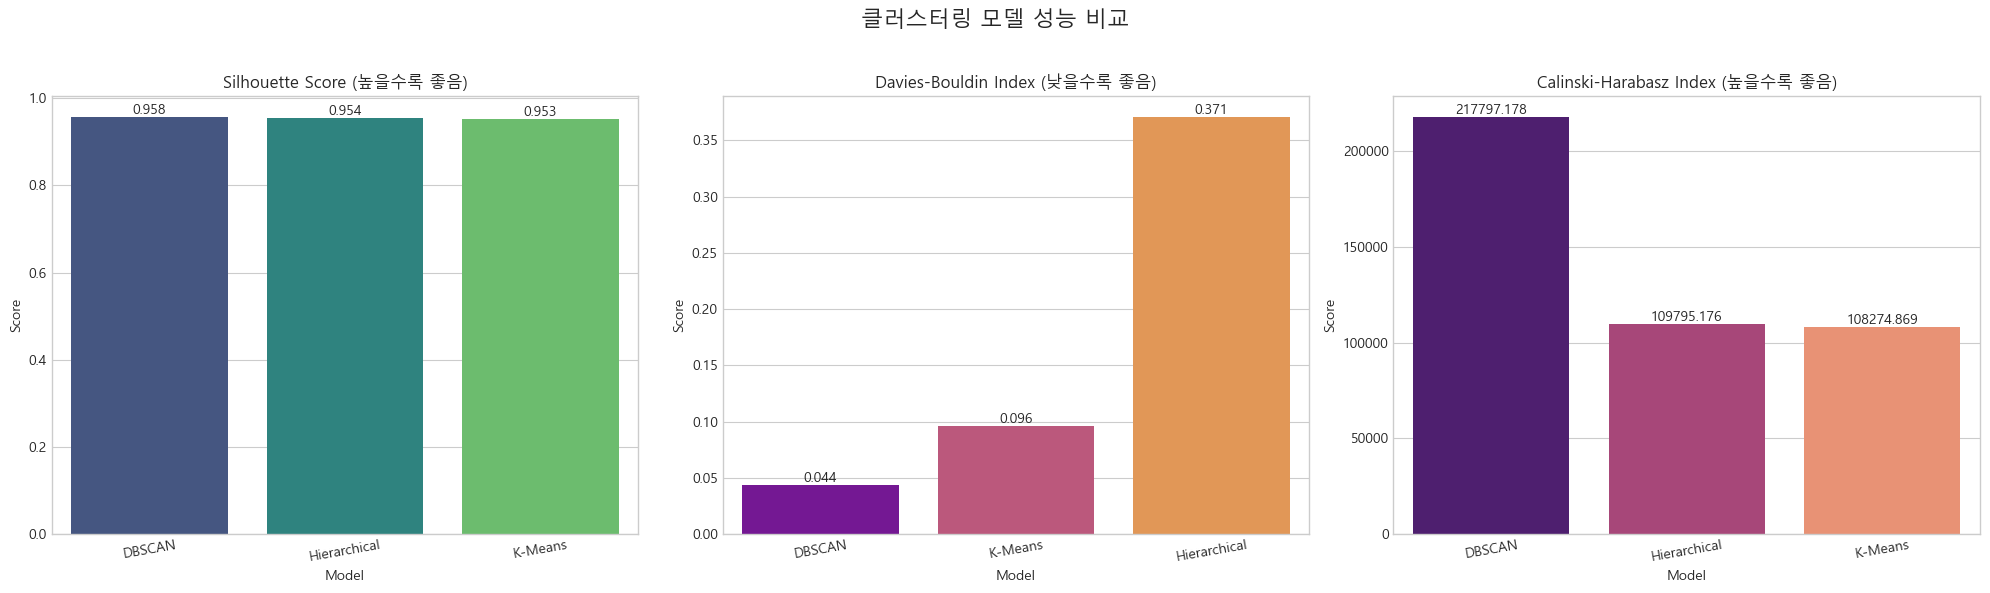

In [13]:
try:
    kmeans = joblib.load(os.path.join(MODEL_DIR, 'kmeans.pkl'))
    dbscan = joblib.load(os.path.join(MODEL_DIR, 'dbscan.pkl'))
    agg_cluster = joblib.load(os.path.join(MODEL_DIR, 'agg_cluster.pkl'))
    X_reduced = np.load(os.path.join(MODEL_DIR, 'X_reduced.npy'))
except FileNotFoundError:
    print("오류: 모델 파일을 찾을 수 없습니다. 'train_model.py'를 먼저 실행해주세요.")
    exit(1)

# 결과를 저장할 딕셔너리
metrics = {}

# --- K-Means 평가 ---
metrics['K-Means'] = {
    'Silhouette': silhouette_score(X_reduced, kmeans.labels_),
    'Davies-Bouldin': davies_bouldin_score(X_reduced, kmeans.labels_),
    'Calinski-Harabasz': calinski_harabasz_score(X_reduced, kmeans.labels_)
}

# --- DBSCAN 평가 ---
labels_db = dbscan.labels_
core_points_mask = labels_db != -1
labels_db_clustered = labels_db[core_points_mask]

if len(set(labels_db_clustered)) < 2:
    print("DBSCAN: 클러스터가 1개 이하이므로 평가지표를 계산하지 않습니다.")
    metrics['DBSCAN'] = {'Silhouette': np.nan, 'Davies-Bouldin': np.nan, 'Calinski-Harabasz': np.nan}
else:
    X_db_clustered = X_reduced[core_points_mask]
    metrics['DBSCAN'] = {
        'Silhouette': silhouette_score(X_db_clustered, labels_db_clustered),
        'Davies-Bouldin': davies_bouldin_score(X_db_clustered, labels_db_clustered),
        'Calinski-Harabasz': calinski_harabasz_score(X_db_clustered, labels_db_clustered)
    }

# --- 계층적 군집화 평가 ---
metrics['Hierarchical'] = {
    'Silhouette': silhouette_score(X_reduced, agg_cluster.labels_),
    'Davies-Bouldin': davies_bouldin_score(X_reduced, agg_cluster.labels_),
    'Calinski-Harabasz': calinski_harabasz_score(X_reduced, agg_cluster.labels_)
}

# 딕셔너리를 DataFrame으로 변환하여 반환
metrics_df = pd.DataFrame(metrics).T
print("--- 모델별 평가 지표 ---")
print(metrics_df)

if metrics_df is None:
    print("평가 지표 데이터가 없어 그래프를 생성할 수 없습니다.")
    exit(1)
    
# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 3개의 지표를 위한 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('클러스터링 모델 성능 비교', fontsize=16)

# 지표별 정보 (제목, 색상 팔레트)
plot_info = {
    'Silhouette': ('Silhouette Score (높을수록 좋음)', 'viridis'),
    'Davies-Bouldin': ('Davies-Bouldin Index (낮을수록 좋음)', 'plasma'),
    'Calinski-Harabasz': ('Calinski-Harabasz Index (높을수록 좋음)', 'magma')
}

# 각 지표에 대해 서브플롯 그리기
for i, (metric, (title, palette)) in enumerate(plot_info.items()):
    # 데이터프레임을 지표 점수 기준으로 정렬
    df_sorted = metrics_df.sort_values(by=metric, ascending=False if '높을수록' in title else True)
    
    ax = axes[i]
    bars = sns.barplot(x=df_sorted.index, y=df_sorted[metric], ax=ax, palette=palette)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Model', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.tick_params(axis='x', rotation=10)

    # 막대 위에 수치 표시
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f'{bar.get_height():.3f}',
                ha='center',
                va='bottom',
                fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Kmeans 최적의 K값 찾기

엘보우 서치를 이용해 최적의 K값을 찾습니다.

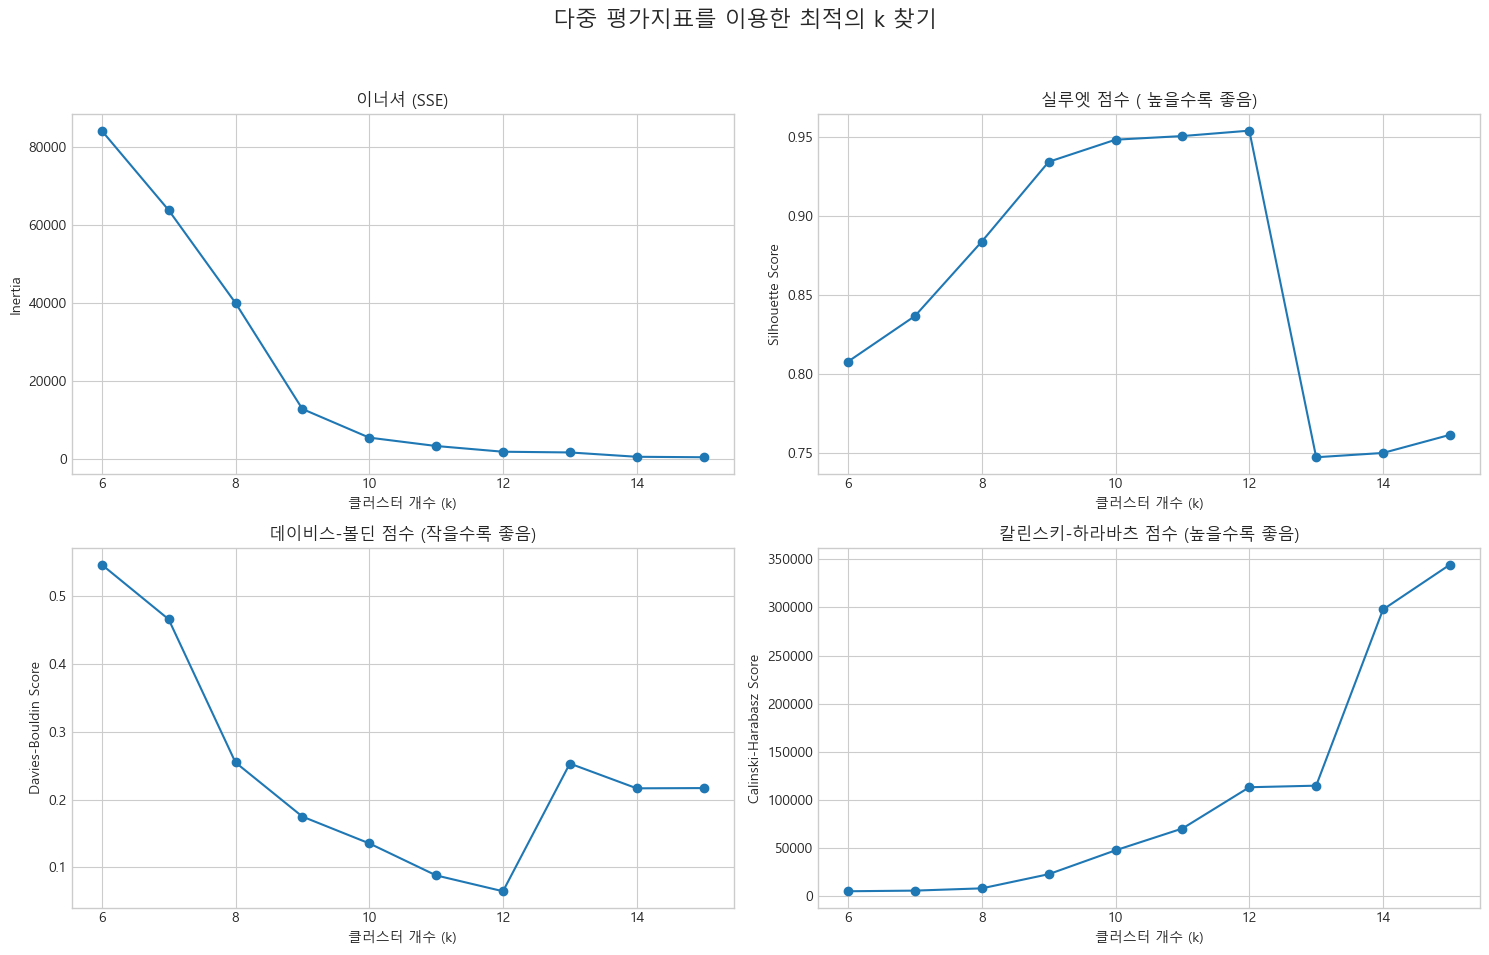

In [10]:
# 엘보우 서치 (최적의 K값 확인)
def elbow_search(max_k=15):
    try:
        X_reduced = np.load(os.path.join(MODEL_DIR, 'X_reduced.npy'))
    except FileNotFoundError:
        print("오류: 모델 파일을 찾을 수 없습니다. 'train_model.py'를 먼저 실행해주세요.")
        exit()

    k_range = range(6, max_k + 1)
    
    inertia_list = []
    silhouette_list = []
    davies_bouldin_list = []
    calinski_harabasz_list = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k,random_state=43,n_init='auto')
        kmeans.fit(X_reduced)
        labels = kmeans.labels_

        # 평가지표 계산 및 저장
        inertia_list.append(kmeans.inertia_)
        silhouette_list.append(silhouette_score(X_reduced, labels))
        davies_bouldin_list.append(davies_bouldin_score(X_reduced, labels))
        calinski_harabasz_list.append(calinski_harabasz_score(X_reduced, labels))
    
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    # 4개의 평가지표를 한 번에 시각화
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('다중 평가지표를 이용한 최적의 k 찾기', fontsize=16)

    # 1. 이너셔 (Elbow Method)
    axs[0, 0].plot(k_range, inertia_list, 'o-')
    axs[0, 0].set_title('이너셔 (SSE)')
    axs[0, 0].set_xlabel('클러스터 개수 (k)')
    axs[0, 0].set_ylabel('Inertia')

    # 2. 실루엣 점수
    axs[0, 1].plot(k_range, silhouette_list, 'o-')
    axs[0, 1].set_title('실루엣 점수 ( 높을수록 좋음)')
    axs[0, 1].set_xlabel('클러스터 개수 (k)')
    axs[0, 1].set_ylabel('Silhouette Score')

    # 3. 데이비스-볼딘 점수
    axs[1, 0].plot(k_range, davies_bouldin_list, 'o-')
    axs[1, 0].set_title('데이비스-볼딘 점수 (작을수록 좋음)')
    axs[1, 0].set_xlabel('클러스터 개수 (k)')
    axs[1, 0].set_ylabel('Davies-Bouldin Score')

    # 4. 칼린스키-하라바츠 점수
    axs[1, 1].plot(k_range, calinski_harabasz_list, 'o-')
    axs[1, 1].set_title('칼린스키-하라바츠 점수 (높을수록 좋음)')
    axs[1, 1].set_xlabel('클러스터 개수 (k)')
    axs[1, 1].set_ylabel('Calinski-Harabasz Score')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

elbow_search()

# 각 모델의 클러스터에 대한 요소의 개수

In [14]:
def print_cluster_counts():
    print("\n" + "="*50)
    print("      각 모델의 클러스터별 요소 개수 출력")
    print("="*50)

    try:
        kmeans = joblib.load(os.path.join(MODEL_DIR, 'kmeans.pkl'))
        dbscan = joblib.load(os.path.join(MODEL_DIR, 'dbscan.pkl'))
        agg_cluster = joblib.load(os.path.join(MODEL_DIR, 'agg_cluster.pkl'))
    except FileNotFoundError:
        print(f"\n오류: 모델 파일을 '{MODEL_DIR}' 폴더에서 찾을 수 없습니다.")
        print("이전 단계의 모델 학습 및 저장 스크립트를 먼저 실행해주세요.")
        return

    print("\n--- K-Means 클러스터별 요소 개수 ---")
    k_labels, k_counts = np.unique(kmeans.labels_, return_counts=True)
    kmeans_counts = dict(zip(k_labels, k_counts))
    for cluster_label, count in sorted(kmeans_counts.items()):
        print(f"  - 클러스터 {cluster_label}: {count} 개")

    print("\n--- DBSCAN 클러스터별 요소 개수 ---")
    d_labels, d_counts = np.unique(dbscan.labels_, return_counts=True)
    dbscan_counts = dict(zip(d_labels, d_counts))
    if -1 in dbscan_counts:
        print(f"  - 노이즈 (-1): {dbscan_counts[-1]} 개")
        del dbscan_counts[-1]

    for cluster_label, count in sorted(dbscan_counts.items()):
        print(f"  - 클러스터 {cluster_label}: {count} 개")

    print("\n--- 계층적 군집화(Agglomerative) 클러스터별 요소 개수 ---")
    a_labels, a_counts = np.unique(agg_cluster.labels_, return_counts=True)
    agg_counts = dict(zip(a_labels, a_counts))
    for cluster_label, count in sorted(agg_counts.items()):
        print(f"  - 클러스터 {cluster_label}: {count} 개")

print_cluster_counts()


      각 모델의 클러스터별 요소 개수 출력

--- K-Means 클러스터별 요소 개수 ---
  - 클러스터 0: 1042 개
  - 클러스터 1: 713 개
  - 클러스터 2: 210 개
  - 클러스터 3: 294 개
  - 클러스터 4: 225 개
  - 클러스터 5: 160 개
  - 클러스터 6: 164 개
  - 클러스터 7: 114 개
  - 클러스터 8: 98 개
  - 클러스터 9: 17 개
  - 클러스터 10: 44 개
  - 클러스터 11: 10 개

--- DBSCAN 클러스터별 요소 개수 ---
  - 클러스터 0: 210 개
  - 클러스터 1: 1042 개
  - 클러스터 2: 160 개
  - 클러스터 3: 713 개
  - 클러스터 4: 98 개
  - 클러스터 5: 44 개
  - 클러스터 6: 225 개
  - 클러스터 7: 294 개
  - 클러스터 8: 12 개
  - 클러스터 9: 10 개
  - 클러스터 10: 164 개
  - 클러스터 11: 17 개
  - 클러스터 12: 102 개

--- 계층적 군집화(Agglomerative) 클러스터별 요소 개수 ---
  - 클러스터 0: 22 개
  - 클러스터 1: 1042 개
  - 클러스터 2: 713 개
  - 클러스터 3: 98 개
  - 클러스터 4: 294 개
  - 클러스터 5: 225 개
  - 클러스터 6: 164 개
  - 클러스터 7: 102 개
  - 클러스터 8: 160 개
  - 클러스터 9: 210 개
  - 클러스터 10: 44 개
  - 클러스터 11: 17 개


# 시각화
t-SNE 모델을 통해 2차원 및 3차원으로 시각화합니다.

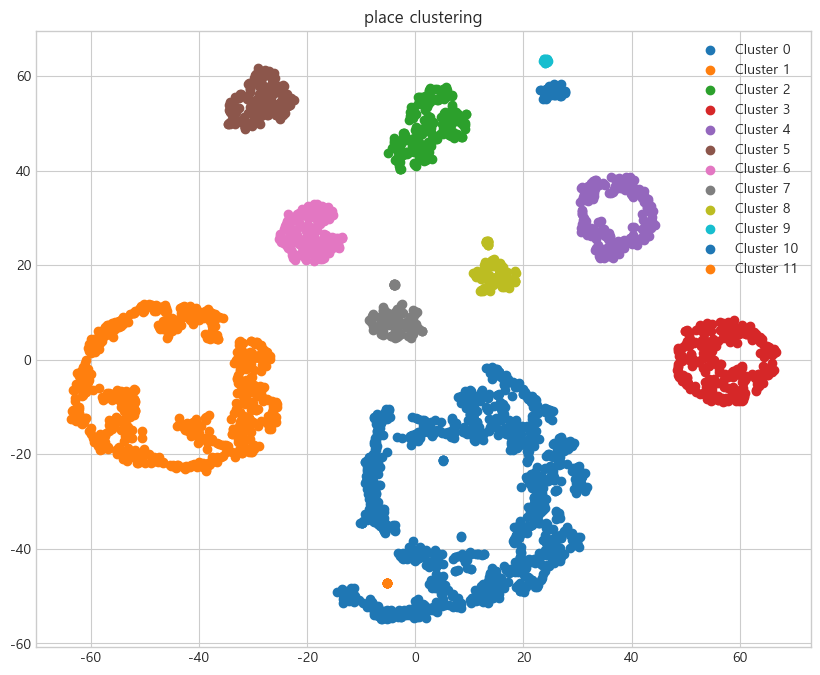

In [15]:
# 클러스터 시각화 2차원 (t-SNE)
def visualize():
    try:
        X_reduced = np.load(os.path.join(MODEL_DIR, 'X_reduced.npy'))
        place_features = pd.read_csv(os.path.join(MODEL_DIR, 'clustered_places.csv'))
    except FileNotFoundError:
        print("오류: 모델 파일을 찾을 수 없습니다. 'train_model.py'를 먼저 실행해주세요.")
        exit()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

    X_tsne = tsne.fit_transform(X_reduced)
    place_features['x'] = X_tsne[:, 0] 
    place_features['y'] = X_tsne[:, 1]

    plt.figure(figsize=(10, 8))
    for i in range(N_CLUSTERS):
        cluster_points = place_features[place_features['cluster'] == i]
        plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {i}')
    plt.title('place clustering')
    plt.legend()
    plt.show()

visualize()

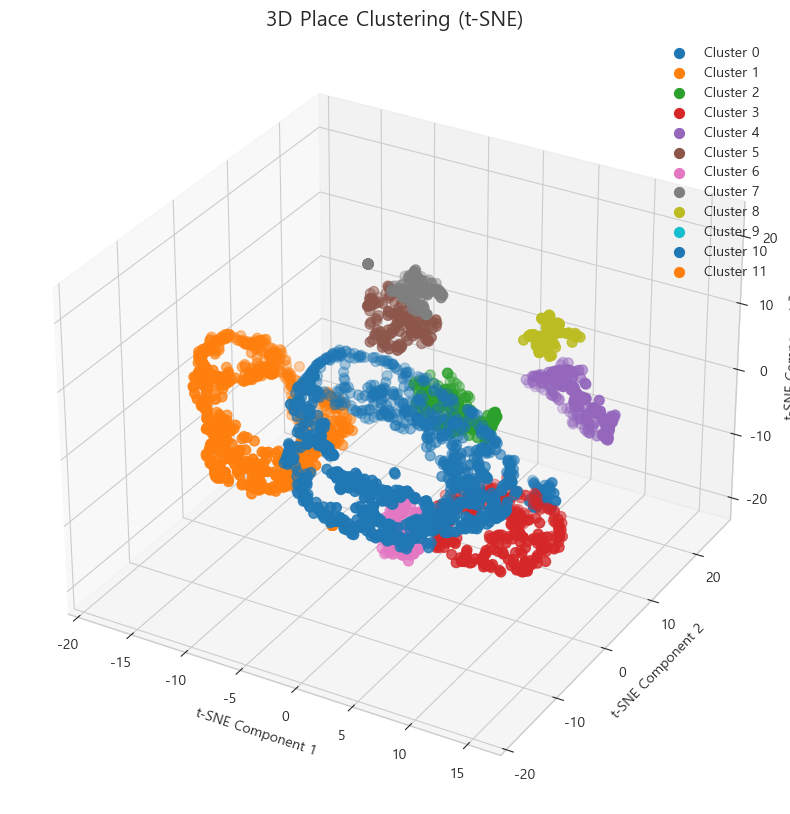

In [16]:
# 클러스터 시각화 3차원 (t-SNE)
def visualize_3d():
    try:
        X_reduced = np.load(os.path.join(MODEL_DIR, 'X_reduced.npy'))
        place_features = pd.read_csv(os.path.join(MODEL_DIR, 'clustered_places.csv'))
    except FileNotFoundError:
        print("오류: 데이터 파일을 찾을 수 없습니다. 'train_model.py' 등으로 파일이 준비되었는지 확인해주세요.")
        return

    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
    X_tsne_3d = tsne_3d.fit_transform(X_reduced)

    place_features['x'] = X_tsne_3d[:, 0] 
    place_features['y'] = X_tsne_3d[:, 1]
    place_features['z'] = X_tsne_3d[:, 2]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(N_CLUSTERS):
        cluster_points = place_features[place_features['cluster'] == i]
        ax.scatter(cluster_points['x'], cluster_points['y'], cluster_points['z'], 
                   label=f'Cluster {i}', s=50)

    ax.set_title('3D Place Clustering (t-SNE)', fontsize=15)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    ax.legend()
    
    plt.show()
    
visualize_3d()

# 가중치 정의

mbti와 날씨 점수 부여를 위한 가중치를 설정합니다.

In [27]:
MBTI_WEIGHTS = {
    "ISTJ": {"레저/스포츠": 0.5, "전통/역사": 1.0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 0.5},
    "ISFJ": {"레저/스포츠": 0, "전통/역사": 1.0, "감성/체험거리": 1.0, "조망/전망": 1.0, "자연물": 1.0, "문화시설감상": 0.5},
    "INFJ": {"레저/스포츠": 0, "전통/역사": 0.5, "감성/체험거리": 1.0, "조망/전망": 1.0, "자연물": 1.0, "문화시설감상": 1.0},
    "INTJ": {"레저/스포츠": 0, "전통/역사": 1.0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 1.0},
    "ISTP": {"레저/스포츠": 1.0, "전통/역사": 0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 1.0, "문화시설감상": 0},
    "ISFP": {"레저/스포츠": 1.0, "전통/역사": 0.5, "감성/체험거리": 1.0, "조망/전망": 1.0, "자연물": 1.0, "문화시설감상": 0.5},
    "INFP": {"레저/스포츠": 0, "전통/역사": 0.5, "감성/체험거리": 1.0, "조망/전망": 1.0, "자연물": 1.0, "문화시설감상": 1.0},
    "INTP": {"레저/스포츠": 0, "전통/역사": 1.0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 1.0},
    "ESTP": {"레저/스포츠": 1.0, "전통/역사": 0, "감성/체험거리": 0.5, "조망/전망": 0, "자연물": 0.5, "문화시설감상": 0},
    "ESFP": {"레저/스포츠": 1.0, "전통/역사": 0, "감성/체험거리": 1.0, "조망/전망": 1.0, "자연물": 0.5, "문화시설감상": 0},
    "ENFP": {"레저/스포츠": 1.0, "전통/역사": 0.5, "감성/체험거리": 1.0, "조망/전망": 0.5, "자연물": 1.0, "문화시설감상": 1.0},
    "ENTP": {"레저/스포츠": 1.0, "전통/역사": 0.5, "감성/체험거리": 0.5, "조망/전망": 0, "자연물": 0.5, "문화시설감상": 1.0},
    "ESTJ": {"레저/스포츠": 0.5, "전통/역사": 1.0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 0.5},
    "ESFJ": {"레저/스포츠": 0.5, "전통/역사": 1.0, "감성/체험거리": 1.0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 0.5},
    "ENFJ": {"레저/스포츠": 0.5, "전통/역사": 1.0, "감성/체험거리": 1.0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 1.0},
    "ENTJ": {"레저/스포츠": 1.0, "전통/역사": 1.0, "감성/체험거리": 0, "조망/전망": 0.5, "자연물": 0.5, "문화시설감상": 0.5},
}

WEATHER_WEIGHTS = {
    '맑음': 1.0,
    '구름많음': 1.0,
    '흐림': 1.0,
    '비': -1.0,
    '비/눈': -1.0,
    '눈': -1.0,
    '소나기': -1.0
}


# Kakao API

경로 탐색 및 제공을 위한 Kakao api 코드를 정의합니다.

In [28]:
import warnings
from dotenv import load_dotenv
import requests
import folium
from openrouteservice import Client
import os

load_dotenv()

# 'Server down'으로 시작하는 UserWarning 메시지를 무시하도록 필터링 설정
warnings.filterwarnings('ignore', message='Server down.*', category=UserWarning)

KAKAO_API_KEY = os.environ.get('KAKAO_API_KEY')
ORS_API_KEY = os.environ.get('ORS_API_KEY')

# 주소나 장소명을 좌표로 수정(is_address: True이면 주소, False이면 장소명)
def get_coordinates_unified(query, is_address=True):
    if isinstance(query, tuple) and len(query) == 2:
        return query
    
    if not isinstance(query, str):
        print(f"잘못된 입력: {query}")
        return None

    try:
        if is_address:
            url = f'https://dapi.kakao.com/v2/local/search/address.json?query={query}'
        else:
            url = f'https://dapi.kakao.com/v2/local/search/keyword.json?query={query}'
        headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
        response = requests.get(url, headers=headers).json()
        documents = response.get('documents', [])
        if not documents:
            print(f"'{query}' → 좌표 변환 실패")
            return None
        x, y = float(documents[0]['x']), float(documents[0]['y'])
        return (x, y)
    except Exception as e:
        print(f"좌표 변환 중 오류: {e}")
        return None

# 경로 좌표 가져오기   
def get_route_coordinates(start_coords, end_coords):
    try:
        client = Client(key=ORS_API_KEY)
        coords = [start_coords, end_coords]
        route = client.directions(coords, profile='driving-car', format='geojson')
        geometry = route['features'][0]['geometry']['coordinates']
        return geometry
    except Exception as e:
        print(f"경로 좌표 가져오기 실패: {e}")
        return []

# 도로기준 거리 계산
def get_driving_distance(start_address: str, destination_name: str):
    start_coords = get_coordinates_unified(start_address, is_address=True)
    end_coords = get_coordinates_unified(destination_name, is_address=False)

    if not start_coords:
        print(f"출발 주소 '{start_address}' → 좌표 변환 실패")
        return None
    if not end_coords:
        print(f"도착 장소 '{destination_name}' → 좌표 변환 실패")
        return None

    try:
        client = Client(key=ORS_API_KEY)
        coords = [start_coords, end_coords]
        route = client.directions(coords, profile='driving-car')
        distance_meters = route['routes'][0]['summary']['distance']
        return round(distance_meters / 1000, 2)
    except Exception as e:
        print(f"거리 계산 실패 ({start_address} → {destination_name}) | 최적의 경로를 찾지 못했습니다.")
        return None
    
# 주변 장소 검색 
def search_places(category, lon, lat, radius=1000):
    url = 'https://dapi.kakao.com/v2/local/search/category.json'
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {
        "category_group_code": category,
        "x": lon, "y": lat,
        "radius": radius,
        "size": 15,
        "sort": "distance"
    }
    return requests.get(url, headers=headers, params=params).json()['documents']

# 지도 생성
def create_map_kakao(start, end, route_coords, nearby_places):
    m = folium.Map(location=[start[1], start[0]], zoom_start=13)

    # 출발/도착 마커
    folium.Marker([start[1], start[0]], tooltip='출발지', icon=folium.Icon(color='blue')).add_to(m)
    folium.Marker([end[1], end[0]], tooltip='도착지', icon=folium.Icon(color='red')).add_to(m)

    # 경로 라인
    route_latlon = [[lat, lon] for lon, lat in route_coords]
    folium.PolyLine(route_latlon, color='blue', weight=4).add_to(m)

    # 카테고리 이름에 따라 색상을 매핑하는 딕셔너리
    color_map = {
        '카페': 'green',
        '음식점': 'orange',
        '관광명소': 'purple'
        # 필요한 만큼 다른 카테고리와 색상을 추가할 수 있습니다.
    }

    # 주변 장소 마커
    for place in nearby_places:
        lat, lon = float(place['y']), float(place['x'])
        name = place['place_name']
        # API 응답의 'category_group_name'을 가져옵니다.
        category_name = place.get('category_group_name', '')
        
        # color_map에서 카테고리에 해당하는 색상을 찾고, 없으면 기본색(gray)을 사용합니다.
        icon_color = color_map.get(category_name, 'gray')
        
        # 아이콘도 구별되게 설정 (예: 'info-sign', 'cutlery', 'camera')
        # 이 부분은 세부적인 조정을 위해 선택적으로 사용할 수 있습니다.
        
        folium.Marker(
            [lat, lon],
            tooltip=f"{name} ({category_name})",
            icon=folium.Icon(color=icon_color, icon='info-sign')
        ).add_to(m)

    return m

# 날씨 API

날씨 정보 제공을 위한 api 코드를 정의합니다.

In [ ]:
from dotenv import load_dotenv
import pandas as pd
import os
import datetime
import asyncio
import aiohttp

load_dotenv()

script_path = os.getcwd()
script_dir = os.path.dirname(script_path)
locationData = pd.read_csv(f"{script_dir}/data/location(weather).csv")

API_URL = 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst'
SERVICE_KEY = os.environ.get('WEATHER_API_KEY')
REQUEST_HEADERS = {
    "Accept": "*/*",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36",
}

# 시도, 시군구 좌표 추출
def get_coords(sd: str, sgg: str):
    try:
        X = locationData[(locationData["1단계"] == sd) & (locationData["2단계"] == sgg)]["격자 X"].iloc[0]
        Y = locationData[(locationData["1단계"] == sd) & (locationData["2단계"] == sgg)]["격자 Y"].iloc[0]
        return X, Y
    except IndexError:
        print(f"[오류] 위치를 찾을 수 없습니다: {sd} {sgg}")
        return None, None

# 날씨 데이터에서 SKY, PTY 카운트 추출
def process_weather_items(items: list, 날짜: str):
    if not items:
        return None

    data_count = {"맑음": 0, "구름많음": 0, "흐림": 0, "없음": 0, "비": 0, "비/눈": 0, "눈": 0,"소나기": 0}
    sky_code_meaning = {"1": "맑음", "3": "구름많음", "4": "흐림"}
    pty_code_meaning = {"0": "없음", "1": "비", "2": "비/눈", "3": "눈","4": "소나기"}

    for item in items:
        category = item.get("category")
        value = item.get("fcstValue")
        date = item.get("fcstDate")
        if category == 'SKY' and date == 날짜:
            meaning = sky_code_meaning.get(value)
            data_count[meaning] += 1
        elif category == 'PTY' and date == 날짜:
            meaning = pty_code_meaning.get(value)
            data_count[meaning] += 1

    return data_count

# API 요청 함수
async def fetch_api_data(session: aiohttp.ClientSession, payload: dict):
    for attempt in range(5):
        try:
            async with session.get(API_URL, params=payload, timeout=aiohttp.ClientTimeout(total=10.0)) as response:
                response.raise_for_status() 
                weather_data = await response.json()

                header = weather_data.get("response", {}).get("header", {})
                if header.get("resultCode") != "00":
                    print(f"API 오류: {header.get('resultMsg')} (코드: {header.get('resultCode')})")
                    continue
                
                return weather_data.get("response", {}).get("body", {}).get("items", {}).get("item", [])
        except Exception as e:
            print(f"API 요청을 재시도 합니다. (시도 {attempt+1}/5)")
            if attempt < 4:
                await asyncio.sleep(1)
    return None

# 한 행(장소)에 대한 날씨 요청
async def fetch_weather_for_row(session: aiohttp.ClientSession, sd: str, sgg: str, 날짜: str):
    X, Y = get_coords(sd, sgg)
    if X is None:
        return None

    payload = {
        "serviceKey": SERVICE_KEY,
        "numOfRows": 1000,
        "pageNo": 1,
        "dataType": "JSON",
        "base_date": datetime.date.today().strftime("%Y%m%d"),
        "base_time": "0200", # 0200, 0500, 0800, 1100, 1400, 1700, 2000, 2300
        "nx": X,
        "ny": Y,
    }

    items = await fetch_api_data(session, payload)
    if not items:
        print(f"{sd} {sgg}의 날씨 정보를 가져오지 못했습니다.")
        return None
            
    return process_weather_items(items, 날짜)

# 여러 장소(데이터프레임)에 대한 날씨 요청
async def get_weather_for_dataframe_async(df: pd.DataFrame, 날짜: str):
    tasks = []
    async with aiohttp.ClientSession(headers=REQUEST_HEADERS) as session:
        for _, row in df.iterrows():
            task = fetch_weather_for_row(session, row['SIDO_NM'], row['SGG_NM'], 날짜)
            tasks.append(task)
        
        # asyncio.gather를 사용하여 모든 작업을 동시에 실행하고 결과를 받음
        # return_exceptions=True로 설정하면 개별 작업에서 예외 발생 시 gather가 중단되지 않고 예외 객체를 결과 리스트에 포함
        results = await asyncio.gather(*tasks, return_exceptions=True)

    return results

# 종합 처리 로직

사용자로부터 입력을 받은 후 날씨 및 경로 api 메서드를 호출하여 장소를 추천합니다.

In [ ]:
# 날씨, 경로 추천 등을 위한 라이브러리 및 파일
import sys
import tabulate
import webbrowser

# 저장된 모델과 클러스터링 분류 데이터 가져오기
try:
    scaler = joblib.load(os.path.join(MODEL_DIR, 'scaler.pkl'))
    reducer = joblib.load(os.path.join(MODEL_DIR, 'reducer.pkl'))
    kmeans = joblib.load(os.path.join(MODEL_DIR, 'kmeans.pkl'))
    dbscan = joblib.load(os.path.join(MODEL_DIR, 'dbscan.pkl'))
    agg_cluster = joblib.load(os.path.join(MODEL_DIR, 'agg_cluster.pkl'))
    X_reduced = np.load(os.path.join(MODEL_DIR, 'X_reduced.npy'))
    place_features = pd.read_csv(os.path.join(MODEL_DIR, 'clustered_places.csv'))
except FileNotFoundError:
    print("오류: 모델 파일을 찾을 수 없습니다. 'train_model.py'를 먼저 실행해주세요.")
    exit()

async def recommend_places(mbti: str, 계절: str, 현재주소: str, 날짜: str):
    get_weight = MBTI_WEIGHTS.get(mbti.upper()) # 대문자 변환
    if not get_weight:
        raise ValueError(f"MBTI 유형 '{mbti}'를 찾을 수 없습니다.")

    # 사용자의 특성 점수 계산
    레저_스포츠 = get_weight["레저/스포츠"]
    전통_역사 = get_weight["전통/역사"]
    감성_체험거리 = get_weight["감성/체험거리"]
    조망_전망 = get_weight["조망/전망"]
    자연물 = get_weight["자연물"]
    문화시설감상 = get_weight["문화시설감상"]
    자연_조망_결합 = 자연물 * 조망_전망
    자연_역사_결합 = 자연물 * 전통_역사
    자연_레저_결합 = 자연물 * 레저_스포츠
    자연_체험_결합 = 자연물 * 감성_체험거리
    조망_체험_결합 = 조망_전망 * 감성_체험거리
    조망_역사_결합 = 조망_전망 * 전통_역사
    역사_문화_결합 = 전통_역사 * 문화시설감상
    레저_체험_결합 = 레저_스포츠 * 감성_체험거리

    user_features_data = [[
        레저_스포츠, 전통_역사, 감성_체험거리, 조망_전망, 자연물, 문화시설감상,
        자연_조망_결합, 자연_역사_결합, 자연_레저_결합, 자연_체험_결합, 
        역사_문화_결합, 레저_체험_결합, 조망_체험_결합, 조망_역사_결합
    ]]
    user_features_df = pd.DataFrame(user_features_data, columns=scaler.feature_names_in_)

    # 스케일링 > UMAP > 모델 예측
    user_scaled = scaler.transform(user_features_df)
    user_reduced = reducer.transform(user_scaled)
    user_umap_point = user_reduced[0] # 사용자의 UMAP 공간 좌표

    N_CLOSEST_CLUSTERS = 4 # 가장 가까운 클러스터 3개 선택
    K_ITEMS_PER_CLUSTER = 3 # 각 클러스터에서 상위 4개 장소 선택
    # 중심점으로부터 거리 계산 및 가까운 클러스터 선정
    cluster_centroids = kmeans.cluster_centers_
    distances_to_centroids = np.sqrt(np.sum((cluster_centroids - user_umap_point)**2, axis=1))
    closest_cluster_labels = np.argsort(distances_to_centroids)[:N_CLOSEST_CLUSTERS]
    
    recommended_places_list = []
    # 각 클러스터별 장소 간 거리 계산 및 정렬
    for cluster_label in closest_cluster_labels:
        df_current_cluster_season = place_features[
            (place_features['cluster'] == cluster_label) &
            (place_features[계절] == 1)].copy()
        
        if df_current_cluster_season.empty:
            continue
        
        indices_in_X_reduced = df_current_cluster_season.index
        points_for_distance_calc = X_reduced[indices_in_X_reduced]
        
        distances_per_place = np.sqrt(np.sum((points_for_distance_calc - user_umap_point)**2, axis=1))
        df_current_cluster_season['distance'] = distances_per_place
        # 최종 K_ITEMS_PER_CLUSTER 만큼 반환
        top_k_in_cluster = df_current_cluster_season.sort_values('distance').head(K_ITEMS_PER_CLUSTER)
        recommended_places_list.append(top_k_in_cluster)

    final_recommendations_df = pd.concat(recommended_places_list).sort_values('distance')

    # 실제 거리 계산 (수정한 부분)
    final_recommendations_df['real_distance_km'] = final_recommendations_df['ITS_BRO_NM'].apply(
    lambda place: get_driving_distance(현재주소, place)
    )

    # 날씨 정보를 받아오고 이를 기존 df에 병합
    weather_results = await get_weather_for_dataframe_async(final_recommendations_df, 날짜)

    # 통신 문제 등으로 인해 날씨 정보를 받지 못하면 거리 기준으로만 반환
    if weather_results is not None:
        df_current = pd.DataFrame(pd.Series(weather_results), columns=['data_dict'])
        df_expanded = df_current['data_dict'].apply(pd.Series)
        df_expanded.index = final_recommendations_df.index
        df_merged = final_recommendations_df.join(df_expanded)

        # 날씨 점수 계산 및 정규화
        scaler2 = MinMaxScaler()
        weather_cols = [col for col in WEATHER_WEIGHTS.keys() if col in df_merged.columns]
        df_merged['WeatherScore'] = sum(df_merged[col] * WEATHER_WEIGHTS[col] for col in weather_cols)

        # 거리 값이 여러 개일 때만 정규화 수행
        if len(df_merged['distance'].unique()) > 1:
            df_merged['distance_score'] = 1 - scaler2.fit_transform(df_merged[['distance']])
        else:
            df_merged['distance_score'] = 1.0

        # 날씨 점수 값이 여러 개일 때만 정규화 수행
        if len(df_merged['WeatherScore'].unique()) > 1:
            df_merged['weather_score_normalized'] = scaler2.fit_transform(df_merged[['WeatherScore']])
        else:
            df_merged['weather_score_normalized'] = 1.0
        
        distance_weight = 0.7
        weather_weight = 0.3
        INDOOR_TYPE_VALUE = 1
        # 날씨 점수는 실외 장소에만 반영하고 최종 점수가 높은 순으로 정렬하여 반환
        df_merged['FinalScore'] = np.where(
            df_merged['In/Out_Type(1/0)'] == INDOOR_TYPE_VALUE,
            df_merged['distance_score'],  # 조건: 실내일 경우 최종 점수는 거리 점수와 동일, 실외는 날씨 점수 반영
            (df_merged['distance_score'] * distance_weight) + (df_merged['weather_score_normalized'] * weather_weight)  
        )
        return df_merged.sort_values(by='FinalScore', ascending=False)
    else:
        return final_recommendations_df

def show_route(recommendations, 주소):
    print("\n--- 추천 장소 목록 ---")

    print(tabulate.tabulate(
    recommendations.dropna(subset=['real_distance_km'])[['ITS_BRO_NM', 'SIDO_NM', 'SGG_NM', 'FinalScore', 'real_distance_km']],
    headers='keys', tablefmt='pretty'))
    print("\n추천된 장소 리스트 입니다. (경로 추천이 가능한)")
    for idx, row in recommendations.iterrows():
        if pd.notna(row['real_distance_km']):
            print(f"- {row['ITS_BRO_NM']}")

    sys.stdout.flush()
    
    selected_place = input("도착지로 설정할 장소명을 정확히 입력하세요 : ")

    start_coords = get_coordinates_unified(주소, is_address=True)
    end_coords = get_coordinates_unified(selected_place, is_address=False)

    route_coords = get_route_coordinates(start_coords, end_coords)
    if not route_coords:
        print("경로 계산 실패 - 경로가 반환되지 않았습니다.")
        return
    
    search_categories = {
        'CE7': '카페',
        'FD6': '음식점',
        'AT4': '관광명소'
    }

    end_lon, end_lat = end_coords
    all_nearby_places = [] # 모든 검색 결과를 담을 리스트

    print(f"\n--- '{selected_place}' 주변 장소 검색 ---")
    # 2. 정의된 카테고리 목록을 순회하며 장소를 검색하고 리스트에 추가합니다.
    for code, description in search_categories.items():
        print(f"-> 주변 {description} 목록을 검색합니다...")
        # search_places 함수를 호출하여 결과를 받아옴
        places = search_places(code, end_lon, end_lat)
        all_nearby_places.extend(places) # 검색 결과를 전체 리스트에 추가

    # 3. 통합된 장소 목록을 지도 생성 함수에 전달합니다.
    m = create_map_kakao(start_coords, end_coords, route_coords, all_nearby_places)

    m.save("selected_route_map.html")
    webbrowser.open("selected_route_map.html")


# 입력

경로의 경우 별도 html 창에 표시됩니다.

In [ ]:
mbti = input('mbti를 입력하세요 : ')
계절 = input('계절을 입력하세요(봄/여름/가을/겨울) : ')
주소 = input('현재 위치 도로명 주소를 입력하세요 (예: 서울특별시 성북구 삼선교로16길 116): ')
날짜 = input('가고 싶은 날짜 (현재로부터 4일 이내)를 입력하세요 (예: 20250619): ')
계절_map = {
    '봄': 'SEASON_SPRING', '여름': 'SEASON_SUMMER',
    '가을': 'SEASON_AUTUMN', '겨울': 'SEASON_WINTER'
}
계절 = 계절_map.get(계절)
if not 계절:
    raise ValueError("계절 입력 오류") 

recommendations = await recommend_places(mbti, 계절, 주소, 날짜)
show_route(recommendations, 주소)


--- 추천 장소 목록 ---
+------+-------------------------+----------------+----------+---------------------+------------------+
|      |       ITS_BRO_NM        |    SIDO_NM     |  SGG_NM  |     FinalScore      | real_distance_km |
+------+-------------------------+----------------+----------+---------------------+------------------+
| 2787 |      남산서울타워       |   서울특별시   |  용산구  |         1.0         |       8.05       |
| 2786 |        사랑나무         |    충청남도    |  부여군  |  0.879999988079071  |      214.96      |
| 2788 |        동락공원         |    경상북도    |  구미시  | 0.8399999284744263  |      254.13      |
| 3076 |    내수전일출전망대     |    경상북도    |  울릉군  | 0.4833987683057785  |      420.51      |
| 2156 |        평화누리         |     경기도     |  파주시  | 0.4340213418006897  |      62.87       |
| 3028 |    앞산해넘이전망대     |   대구광역시   |   남구   | 0.34166624009609226 |      286.98      |
| 2887 |     연천전곡리유적      |     경기도     |  연천군  | 0.3001151144460891  |      58.24       |
| 3044 |       적상전망대        | 전

# 실험 환경 정보

In [ ]:
aiohttp==3.12.7
folium==0.19.7
imbalanced-learn==0.13.0
joblib==1.4.2
matplotlib==3.10.1
nest-asyncio==1.6.0
numpy==1.26.4
openrouteservice==2.3.3
pandas==2.2.3
python-dotenv==1.1.0
requests==2.32.3
scikit-learn==1.6.1
seaborn==0.13.2
tabulate==0.9.0
umap-learn==0.5.7